# BASELINE

### 코드 설명
- 1) 하단의 코드를 통해 전처리 진행
    - (1) 이미지와 json 파일을 불러와
    - (2) BoundingBox를 기준으로 이미지를 Crop
    - (3) 새로운 폴더에 이미지 파일을 저장
- 2) 모델링 부분부터 재시작
    - (1) 새롭게 저장한 데이터를 train_images와 targets에 저장
    - (2) VGG16 모델에 적용
    - (3) test 데이터는 폴더 단위로 불러와 예측값의 평균 적용
    - (4) 저장 후 제출

In [1]:
# ! rm -r ./open/new_images/test2

In [2]:
# ! unzip ./open.zip -d ./open

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Oct  4 14:44:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   40C    P0    70W / 300W |    570MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

### Library

In [4]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm


# 파일경로 설정
import os
import json

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt


In [5]:
data_path = './open'


train_path = data_path + '/train'
test_path = data_path + '/test'

new_image_directory = data_path + '/new_images'
new_train_image_directory = new_image_directory + '/train2'
new_test_image_directory = new_image_directory + '/test2'

action_information = pd.read_csv(data_path + '/action_information.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

In [6]:
def make_new_dir(path) : 
    if os.path.isdir(path) == False:
        os.makedirs(path)

In [7]:
make_new_dir(new_image_directory)
make_new_dir(new_train_image_directory)
make_new_dir(new_test_image_directory)

### Check Sample Data

#### Train 폴더 데이터 확인

In [8]:
# Train 데이터에 있는 폴더를 glob로 불러와
# sorted method를 통해 숫자 순으로 정렬합니다.
train_folders = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1].replace('file_','')))
test_folders  = sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1].replace('file_','')))
train_folders[:5]

['./open/train/file_0',
 './open/train/file_1',
 './open/train/file_2',
 './open/train/file_3',
 './open/train/file_4']

In [9]:
action_information

,action,Label
0,우측에서 좌측으로,0
1,전방정지,1
2,전후방 동시정지,2
3,좌우측방 동시정지,3
4,좌측에서 우측으로,4
5,후방정지,5


#### 한개의 폴더를 열어 확인

In [10]:
train_folder = train_folders[0]

image_paths = sorted(glob(train_folder + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
json_path   = glob(train_folder + '/*.json')[0]

(2160, 3840, 3)


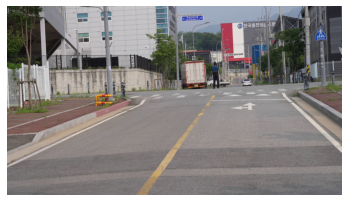

In [11]:
image_path = image_paths[0]
img = Image.open(image_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [12]:
js = json.load(open(json_path))

print("json keys             : ", js.keys())
print("json action info       : ",js.get('action'))
print("json sequence info       : ",js.get('sequence').keys())
print("json info keys : ",js.get('info').keys())

json keys             :  dict_keys(['action', 'sequence', 'info'])
json action info       :  5
json sequence info       :  dict_keys(['image_nums', '2d_pos', 'bounding_box', 'image_height', 'image_width'])
json info keys :  dict_keys(['actor_gender', 'actor_tall_range', 'actor_cloth', 's_height', 'lain_no', 's_dynamic', 's_weather', 's_season', 'direction'])


In [13]:
classes = pd.get_dummies(action_information[['Label']], columns = ['Label']).to_numpy()
classes

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [14]:
image = Image.open(image_path)
bounding_box = js.get('info').get('bounding_box')

[2322.63, 623.07, 2452.81, 954.314]


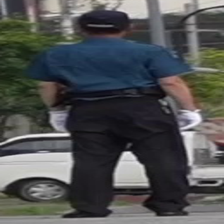

In [15]:
bounding_box = js.get('sequence').get('bounding_box')[0]
bounding_box = [float(x) for x in bounding_box]
print(bounding_box)
image = Image.open(image_path)
image = image.crop(bounding_box) # left top right bottom
image = image.resize((224,224))
image

## Save Data to Another Path

In [16]:
train_directories = np.array(sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1])))

for train_directory in tqdm(train_directories, total = len(train_directories)) : 
    file_name = train_directory.split('/')[-1]
    make_new_dir(new_train_image_directory + '/'+file_name)
    
    image_paths = sorted(glob(train_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    json_path   = glob(train_directory + '/*.json')[0]

    js = json.load(open(json_path))
    target = js.get('action')
    target = classes[target]
    bounding_boxes = js.get('sequence').get('bounding_box')
    bounding_boxes = [(float(a),float(b),float(c),float(d)) for a,b,c,d in bounding_boxes] # 실수형태로 변환, (left, top, right, bottom)

    for image_path, bounding_box in zip(image_paths[20:60], bounding_boxes[20:60]) : 
        image = Image.open(image_path)
        image = image.crop(bounding_box) # left top right bottom
        image = image.resize((224,224))
        image.save(new_train_image_directory + image_path.split('/train')[1])        
        
    for image_path, bounding_box in zip(image_paths[90:120], bounding_boxes[90:120]) : 
        image = Image.open(image_path)
        image = image.crop(bounding_box) # left top right bottom
        image = image.resize((224,224))
        image.save(new_train_image_directory + image_path.split('/train')[1])     

100%|██████████| 142/142 [15:24<00:00,  6.51s/it]


In [17]:
test_directories = np.array(sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1])))

for test_directory in tqdm(test_directories, total = len(test_directories)) : 
    file_name = test_directory.split('/')[-1]
    make_new_dir(new_test_image_directory + '/'+file_name)
    
    image_paths = sorted(glob(test_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    json_path   = glob(test_directory + '/*.json')[0]

    js = json.load(open(json_path))
    target = js.get('action')
    target = classes[target]
    bounding_boxes = js.get('sequence').get('bounding_box')
    bounding_boxes = [(float(a),float(b),float(c),float(d)) for a,b,c,d in bounding_boxes] # 실수형태로 변환, (left, top, right, bottom)

    for image_path, bounding_box in zip(image_paths[20:60], bounding_boxes[20:60]) : 
        image = Image.open(image_path)
        image = image.crop(bounding_box) # left top right bottom
        image = image.resize((224,224))
        image.save(new_test_image_directory + image_path.split('/test')[1])        
    for image_path, bounding_box in zip(image_paths[90:120], bounding_boxes[90:120]) : 
        image = Image.open(image_path)
        image = image.crop(bounding_box) # left top right bottom
        image = image.resize((224,224))
        image.save(new_test_image_directory + image_path.split('/test')[1])        

100%|██████████| 45/45 [04:49<00:00,  6.42s/it]


# Restart & Modeling

In [18]:
# Modeling
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16 # 모델은 가벼운 모델을 사용합니다.
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# GPU 환경 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1"

import gc
from keras import backend as k

# 파일경로 설정
import json

# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [19]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2909903156924536792,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 31906856960
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 14804670480003601195
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 32018006016
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 11790371577416267788
 physical_device_desc: "device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0"]

In [20]:
data_path = './open'


train_path = data_path + '/train'
test_path = data_path + '/test'

new_image_directory = data_path + '/new_images'
new_train_image_directory = new_image_directory + '/train'
new_test_image_directory = new_image_directory + '/test'

action_information = pd.read_csv(data_path + '/action_information.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

classes = pd.get_dummies(action_information[['Label']], columns = ['Label']).to_numpy()

In [21]:
new_train_image_directories = sorted(glob(new_train_image_directory + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1]))
new_train_image_directories[:5]

['./open/new_images/train/file_0',
 './open/new_images/train/file_1',
 './open/new_images/train/file_2',
 './open/new_images/train/file_3',
 './open/new_images/train/file_4']

In [22]:
train_answer = []
train_image_directories = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('_')[-1]))
for train_image_directory in train_image_directories : 
    json_path = glob(train_image_directory + '/*.json')[0]
    js = json.load(open(json_path))
    action = js.get('action')
    train_answer.append(action)

In [23]:
image_size = 224

In [24]:
images = []
targets = []
stratify = []
for num, (new_train_image_directory, action) in tqdm(enumerate(zip(new_train_image_directories, train_answer)), total = len(new_train_image_directories)) : 
    image_paths = sorted(glob(new_train_image_directory + '/*'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    image_len = len(image_paths)
    for image_path in image_paths[10:60] : 
        img = image.load_img(image_path, target_size=(image_size,image_size,3))
        img = image.img_to_array(img)
        img = img/255
        images.append(img)
        targets.append(classes[action])
        stratify.append(action)

images = np.array(images)
targets = np.array(targets)

100%|██████████| 102/102 [00:06<00:00, 16.05it/s]


In [25]:
print(images.shape)
print(targets.shape)

(5094, 224, 224, 3)
(5094, 6)


In [26]:
# train_idx, valid_idx = train_test_split(range(images.shape[0]), test_size = 0.2, stratify = stratify)

# X_train = images[train_idx]
# y_train = targets[train_idx]

# X_valid = images[valid_idx]
# y_valid = targets[valid_idx]

# print('X_train shape : ', X_train.shape)
# print('X_valid shape : ', X_valid.shape)
# print('y_train shape : ', y_train.shape)
# print('y_valid shape : ', y_valid.shape)

In [27]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [28]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
#                 rotation_range = 10,
#                 width_shift_range=0.05,
#                 height_shift_range=0.05,
#                 shear_range=0.05,
#                 zoom_range=0.05
            )

valgen = ImageDataGenerator(
        )

In [29]:
# ! pip install adabelief_tf 
from adabelief_tf import AdaBeliefOptimizer

In [30]:
# !pip install --quiet vit-keras
from vit_keras import vit

In [31]:
# ! pip install -U tensorflow-addons
import tensorflow_addons as tfa

In [32]:
def vit_model():
    
    vit_base = vit.vit_b32(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = classes.shape[1])
#     vit_base.summary()
    
    model = Sequential()
    model.add(vit_base)
#     model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())

    model.add(BatchNormalization())
#     model.add(Dense(256, activation = tfa.activations.gelu))
#     model.add(BatchNormalization())
    model.add(Dense(128, activation = tfa.activations.gelu))
    model.add(BatchNormalization())
#     model.add(Dense(32, activation = tfa.activations.gelu))
#     model.add(BatchNormalization())
    model.add(Dense(64, activation = tfa.activations.gelu))
    model.add(BatchNormalization())
    model.add(Dense(classes.shape[1], activation = "softmax"))
    

    return model


In [33]:
max_rate = 1e-3
min_rate = 1e-4
cycle = 10

In [34]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100

In [35]:
from keras.callbacks import Callback
from keras import backend as K
import math
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, n_epochs, lr_max, lr_min, n_cycle, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.n_epochs = n_epochs
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.n_cycle = n_cycle
        self.lrates = list()
        self.verbose = verbose
        
    def cosine_annealing(self, epoch):
        
        epochs_per_cycle = math.floor(self.n_epochs/self.n_cycle)
        cos_inner = (math.pi * (epoch % (epochs_per_cycle))) / (epochs_per_cycle)
        
        return (self.lr_max - self.lr_min)/2 * (tf.math.cos(cos_inner) + 1) + self.lr_min
     
    def plot(self, epoch):
        lr = self.cosine_annealing(epoch)
        self.lrates.append(lr)
        
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.cosine_annealing(epoch)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose == 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


# kfold = KFold(n_splits=5, shuffle=True)
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

fold_no = 1
for e, (train, val) in enumerate(skf.split(images, np.argmax(targets, axis=1))):


    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    
    X_train = images[train]
    y_train = targets[train]
    X_valid = images[val]
    y_valid = targets[val]
    
#     modelpath = "./vit_model/vit_aug_{epoch:02d}-{val_loss:.4f}_fold_%d.hdf5" % fold_no
    checkpoint = ModelCheckpoint('./vit_model'+f'/check{e}_b32.h5', verbose=1, save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

    AdaBelief = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-8, weight_decay=1e-2)
#     cosine_scheduler = CosineAnnealingScheduler(num_epochs, max_rate, min_rate, cycle)
#     optimizer = tfa.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     )
    
#     learning_rate = 1e-4

#     optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

    with strategy.scope():
        model = vit_model()
        model.compile(loss='categorical_crossentropy',optimizer=AdaBelief, metrics=['accuracy'])

#     for i in range(1, num_epochs + 1):
#         cosine_scheduler.plot(i)

#     plt.plot(cosine_scheduler.lrates)
#     plt.title('Cosine Annealing_Toy')
#     plt.xlabel('epochs'); plt.ylabel('learning_rate')
#     plt.grid()
#     plt.show()

#     training_generator = datagen.flow(X_train, y_train, batch_size=batch_size, seed=77, shuffle=True)
#     validation_generator = valgen.flow(X_valid, y_valid, batch_size=batch_size, seed=77, shuffle=True)
    history = model.fit(
        X_train, y_train, 
        validation_data = (X_valid,y_valid),
        verbose = 1,
        shuffle=True,
        epochs=num_epochs,
        callbacks=[checkpoint, early_stopping_callback]
    )
    
#     history = model.fit(
#         training_generator,
#         shuffle=True,
#         steps_per_epoch =len(X_train)//batch_size,
#         epochs=num_epochs,
#         validation_data=validation_generator,
#         callbacks=[checkpoint, early_stopping_callback,cosine_scheduler]
#     )
    
    
    fold_no += 1


------------------------------------------------------------------------
Training for fold 1 ...
Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.0)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



Epoch 4/100
128/128 [==============================] - 22s 174ms/step - loss: 0.0681 - accuracy: 0.9855 - val_loss: 0.0138 - val_accuracy: 0.9971

Epoch 00004: val_loss did not improve from 0.01262
Epoch 5/100
128/128 [==============================] - 22s 175ms/step - loss: 0.0406 - accuracy: 0.9897 - val_loss: 0.0165 - val_accuracy: 0.9961

Epoch 00005: val_loss did not improve from 0.01262
Epoch 6/100
128/128 [==============================] - 22s 174ms/step - loss: 0.0769 - accuracy: 0.9779 - val_loss: 0.0155 - val_accuracy: 0.9961

Epoch 00006: val_loss did not improve from 0.01262
Epoch 7/100
128/128 [==============================] - 22s 170ms/step - loss: 0.0320 - accuracy: 0.9921 - val_loss: 0.0053 - val_accuracy: 0.9990

Epoch 00007: val_loss improved from 0.01262 to 0.00530, saving model to ./vit_model/check1_b32.h5
Epoch 8/100
128/128 [==============================] - 22s 171ms/step - loss: 0.0196 - accuracy: 0.9968 - val_loss: 0.0035 - val_accuracy: 0.9980

Epoch 00008: v

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
# model_name1 = 'vit_aug_10-0.0001_fold_1.hdf5'
# model1 = load_model('./vit_model/%s' % model_name1, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})
# model_name2 = 'vit_aug_10-0.0012_fold_2.hdf5'
# model2 = load_model('./vit_model/%s' % model_name2, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})
# model_name3 = 'vit_aug_10-0.0003_fold_3.hdf5'
# model3 = load_model('./vit_model/%s' % model_name3, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})
# model_name4 = 'vit_aug_07-0.0006_fold_4.hdf5'
# model4 = load_model('./vit_model/%s' % model_name4, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})
# model_name5 = 'vit_aug_07-0.0011_fold_5.hdf5'
# model5 = load_model('./vit_model/%s' % model_name5, custom_objects={'AdaBeliefOptimizer' : AdaBeliefOptimizer})

In [ ]:
# all_model = [model1, model2, model3, model4, model5]

In [ ]:
# import time
# start = time.time()  # 시작 시간 저장

# new_test_image_directory = new_image_directory + '/test'
# new_test_image_directories = sorted(glob(new_test_image_directory + '/*'), key = lambda x : int(x.split('file_')[-1]))

# sub=np.zeros((np.array(new_test_image_directories).shape[0], classes.shape[1])) 

# for e in range(5):
    
#     model = vit_model()
#     model.load_weights('./vit_model'+f'/check{e}_b32.h5')
    
#     predictions = []
#     for new_test_image_directory in tqdm(new_test_image_directories, total = len(new_test_image_directories)) :
#         image_paths = sorted(glob(new_test_image_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
#         image_len = len(image_paths)
#         test_images  = []
#         for image_path in image_paths:
#             img = image.load_img(image_path, target_size=(image_size,image_size,3))
#             img = image.img_to_array(img)
#             img = img/255
#             test_images.append(img)
#         prediction = np.mean(model.predict(np.array(test_images)), axis = 0)
#         predictions.append(prediction)
    
#     sub+=predictions
    
# print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [45]:
import time
start = time.time()  # 시작 시간 저장

new_test_image_directory = new_image_directory + '/test2'
new_test_image_directories = sorted(glob(new_test_image_directory + '/*'), key = lambda x : int(x.split('file_')[-1]))

e = 1
model = vit_model()
model.load_weights('./vit_model'+f'/check{e}_b32.h5')

predictions = []
for new_test_image_directory in tqdm(new_test_image_directories, total = len(new_test_image_directories)) :
    image_paths = sorted(glob(new_test_image_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
    image_len = len(image_paths)
    test_images  = []
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(image_size,image_size,3))
        img = image.img_to_array(img)
        img = img/255
        test_images.append(img)
    prediction = np.mean(model.predict(np.array(test_images)), axis = 0)
    predictions.append(prediction)

    
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

100%|██████████| 45/45 [00:16<00:00,  2.78it/s]

time : 22.078592538833618


In [46]:
predictions

[array([0.00899391, 0.00796251, 0.90087587, 0.07337725, 0.00701098,
        0.00177952], dtype=float32),
 array([9.0544738e-05, 2.5087496e-04, 4.1353441e-04, 3.2214119e-04,
        1.1592880e-02, 9.8733008e-01], dtype=float32),
 array([1.4259794e-04, 2.7346659e-05, 1.4531076e-02, 9.8512757e-01,
        1.4429768e-04, 2.7165855e-05], dtype=float32),
 array([7.4022473e-04, 5.7092193e-04, 7.5950599e-01, 2.8667620e-03,
        5.3227205e-02, 1.8308897e-01], dtype=float32),
 array([9.9921131e-01, 2.4869194e-04, 1.1945504e-04, 9.0899361e-05,
        1.9234372e-04, 1.3748556e-04], dtype=float32),
 array([8.1432414e-01, 3.1124509e-04, 3.9500813e-04, 1.0882830e-04,
        1.8431115e-01, 5.4958346e-04], dtype=float32),
 array([8.2648635e-01, 1.2485912e-01, 3.9756537e-04, 6.3697645e-04,
        4.7591943e-02, 2.7956574e-05], dtype=float32),
 array([2.1974443e-04, 2.6681009e-04, 2.6864241e-04, 6.2315864e-04,
        9.9858397e-01, 3.7755737e-05], dtype=float32),
 array([0.00222821, 0.8359426 , 0.

In [ ]:
# mean_sub = sub/5
# mean_sub.shape

In [ ]:
# mean_sub[0]

In [47]:
sample_submission.iloc[:,1:] = predictions
display(sample_submission.head())
sample_submission.to_csv('./vit32_kfold1_no_aug_1004.csv', index=False)

,file_path,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5
0,./test\file_142,0.008994,0.007963,0.900876,0.073377,0.007011,0.001780
1,./test\file_143,0.000091,0.000251,0.000414,0.000322,0.011593,0.987330
2,./test\file_144,0.000143,0.000027,0.014531,0.985128,0.000144,0.000027
3,./test\file_145,0.000740,0.000571,0.759506,0.002867,0.053227,0.183089
4,./test\file_146,0.999211,0.000249,0.000119,0.000091,0.000192,0.000137
